### 0. (Optional) Extract video file

In [1]:
import cv2
import os

capture = cv2.VideoCapture("test_video.avi")
assert capture.isOpened(), "Cannot open the video file."

num_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Prepare folders
img_filename_fmt = 'dataset/images/frame_{:09d}.jpg'
dirname = os.path.dirname(img_filename_fmt)
os.makedirs(dirname, exist_ok=True)

for ii in range(num_frames):
    _, frame = capture.read()
    cv2.imwrite(img_filename_fmt.format(ii), frame)

capture.release()

### 1. Label images

- Assume all images have same size

In [3]:
import cv2
import os

from collections import OrderedDict
from ipywidgets import IntSlider, Label, Button, HBox
from ipycanvas import MultiCanvas, hold_canvas

thickness = 3
y_ratio = 0.5     # percentile of y-position from the topS
    
# Input images
img_filename_fmt = 'dataset/images/frame_ano_right_{:09d}.jpg'
ann_filename = 'dataset/annotation_right_1F.txt'
ann_dict = OrderedDict()

num_frames = len(os.listdir(os.path.dirname(img_filename_fmt)))

cur_index = 0
height, width = cv2.imread(img_filename_fmt.format(cur_index)).shape[:2]
y_value = int(height * y_ratio)

def set_image():        
    image = cv2.imread(img_filename_fmt.format(cur_index))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    image[y_value-thickness//2:y_value+thickness//2] = (255, 0, 0)

    canvas[0].clear()
    canvas[0].put_image_data(image, 0, 0)
    canvas[0].flush()

    pos = ann_dict.get(img_filename_fmt.format(cur_index))
    if pos is not None:
        handle_mouse_down(pos[0], pos[1])    

    cur_fname.value = 'Current image: {:s} | '.format(img_filename_fmt.format(cur_index))

def handle_mouse_move(xpos, ypos):
    with hold_canvas():
        canvas[1].clear()  # Clear the old animation step
        canvas[1].fill_style = "yellow"
        canvas[1].fill_circle(xpos, y_value, 5)  # Draw the new frame    

def handle_mouse_down(xpos, ypos):    
    with hold_canvas():
        canvas[2].clear()
        canvas[2].fill_style = "green"
        canvas[2].fill_circle(xpos, y_value, 5)  # Draw the new frame    
    cur_pos.value = "({:d}, {:d}) ".format(int(xpos), int(y_value))    
    ann_dict[img_filename_fmt.format(cur_index)] = (xpos, y_value)
    
def handle_slider_change(change):
    global y_value
    y_value = change.new
    set_image()
    canvas[1].clear()
    canvas[2].clear()

def handle_save_button(b):
    with open(ann_filename, 'w') as f:
        for k, v in ann_dict.items():            
            f.write("{:s}\t{:d}\t{:d}\n".format(k, int(v[0]), int(v[1])))    

def handle_prev_button(b):
    global cur_index
    cur_index = max(0, cur_index - 1)
    canvas.clear()
    set_image()

def handle_next_button(b):
    global cur_index
    cur_index = min(num_frames - 1, cur_index + 1)
    canvas.clear()
    set_image()

canvas = MultiCanvas(3, width=width, height=height)
cur_fname = Label(value='', disabled=False)
cur_pos = Label(value='', disabled=True)
yslider = IntSlider(description="Y-bar: ", stype={'description_width': 'initial'}, value=y_value, min=1, max=height-2, step=1)
prev_btn = Button(description='Prev', icon='arrow-left')
next_btn = Button(description='Next', icon='arrow-right')
save_btn = Button(description='Save labels', icon='check')

set_image()
canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_down(handle_mouse_down)
yslider.observe(handle_slider_change, names='value')

prev_btn.on_click(handle_prev_button)
next_btn.on_click(handle_next_button)
save_btn.on_click(handle_save_button)

display(canvas, HBox([cur_fname, cur_pos, yslider]), HBox([prev_btn, next_btn, save_btn]))


MultiCanvas(height=360, width=640)

error: OpenCV(4.5.4) /home/ubuntu/build_opencv/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


error: OpenCV(4.5.4) /home/ubuntu/build_opencv/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


error: OpenCV(4.5.4) /home/ubuntu/build_opencv/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


error: OpenCV(4.5.4) /home/ubuntu/build_opencv/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


error: OpenCV(4.5.4) /home/ubuntu/build_opencv/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### 2. Train a model

In [2]:
# 미리 학습되어 있는 모델로 train하는 모델

import torch
import torchvision

def get_model():
    model = torchvision.models.alexnet(num_classes=2, dropout=0.0)
    return model
    
device = torch.device('cuda')
model = get_model()
model = model.to(device)

In [3]:
import torch
from cnn.center_dataset import CenterDataset

batch_size = 4

dataset = CenterDataset('dataset', random_hflip=False)
train_loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True,
)

In [4]:
import ipywidgets
import torch.nn.functional as f

epoch = 50
learning_rate = 2e-3
#learning_rate = 2e-4
# learning rate가 너무 작으면 gradient descent 천천히 진행 -> global minimum에 도달하는데 많은 시간 소요
# 너무 크면 global minimum 지나칠 수 있음 (발산가능)

epoch_slider = ipywidgets.IntSlider(description='Epochs', value=epoch, min=1, max=200, step=1)
lr_slider = ipywidgets.FloatSlider(description='lr', value=learning_rate, min=1e-4, max=1e-2, step=1e-4, readout_format='.4f')
train_button = ipywidgets.Button(description='Train', icon='tasks')
loss_text = ipywidgets.Textarea(description='Progress', value='', rows=15, layout=ipywidgets.Layout(width="50%", height="auto"))
layout = ipywidgets.VBox([ipywidgets.HBox([epoch_slider, lr_slider, train_button]), loss_text])


def train_model(b):
    global epoch_slider
    for epoch in range(epoch_slider.value):
        loss_text.value += "<<<<< Epoch {:d} >>>>>\n".format(epoch)
        train_step()                


def train_step():
    global model, lr_slider, loss_text, train_loader, device

    try:
        # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr_slider.value, momentum=0.9)

        train_button.disabled = True                
        model = model.train()        

        num_iters = len(train_loader)
        for ii, (images, labels) in enumerate(train_loader):
            # send data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # zero gradients of parameters
            optimizer.zero_grad()

            # execute model to get outputs
            outputs = model(images)

            # compute MSE loss over x coordinates            
            loss = f.mse_loss(outputs, labels, reduction='sum')

            # run backpropogation to accumulate gradients
            loss.backward()

            # step optimizer to adjust parameters
            optimizer.step()

            if ii % 10 == 0:
                xlbl, ylbl = labels[0].cpu()
                xlbl = ( xlbl.item() / 2 + 0.5 ) * 800
                ylbl = ( ylbl.item() / 2 + 0.5 ) * 450

                xpre, ypre = outputs[0].cpu()
                xpre = ( xpre.item() / 2 + 0.5 ) * 800
                ypre = ( ypre.item() / 2 + 0.5 ) * 450

                msg = "[{:04d} / {:04d}] loss: {:.4f} | labels: ({:.2f}, {:.2f}), output: ({:.2f}, {:.2f})\n".format(ii, num_iters, loss.item(), xlbl, ylbl, xpre, ypre)
                loss_text.value += msg                
                    
    except Exception as e:
        print(e)
        pass
        
    model = model.eval()
    torch.save(model.state_dict(), 'road_following_model_right_1F.pth')
    
    train_button.disabled = False
    
train_button.on_click(train_model)    

display(layout)

In [5]:
import PIL.Image
from cnn.center_dataset import TEST_TRANSFORMS

def preprocess(image: PIL.Image):
    device = torch.device('cuda')    
    image = TEST_TRANSFORMS(image).to(device)
    return image[None, ...]

In [6]:
model = get_model()
model.load_state_dict(torch.load('road_following_model_right_1F.pth'))
model = model.to(device)

# from torch2trt import TRTModule
# model = TRTModule()
# model.load_state_dict(torch.load('road_following_model.pth'))

[['dataset/images/frame_000000000.jpg', '308', '301'], ['dataset/images/frame_000000001.jpg', '308', '301'], ['dataset/images/frame_000000047.jpg', '309', '310'], ['dataset/images/frame_000000048.jpg', '308', '339'], ['dataset/images/frame_000000049.jpg', '307', '304'], ['dataset/images/frame_000000050.jpg', '308', '281'], ['dataset/images/frame_000000051.jpg', '301', '302'], ['dataset/images/frame_000000052.jpg', '299', '316'], ['dataset/images/frame_000000053.jpg', '295', '316'], ['dataset/images/frame_000000054.jpg', '290', '325'], ['dataset/images/frame_000000055.jpg', '289', '279'], ['dataset/images/frame_000000056.jpg', '279', '296'], ['dataset/images/frame_000000057.jpg', '268', '325'], ['dataset/images/frame_000000058.jpg', '257', '308'], ['dataset/images/frame_000000059.jpg', '201', '276'], ['dataset/images/frame_000000060.jpg', '213', '290'], ['dataset/images/frame_000000061.jpg', '214', '310'], ['dataset/images/frame_000000062.jpg', '134', '290']]
[[-0.02856232  0.7676717 ]]

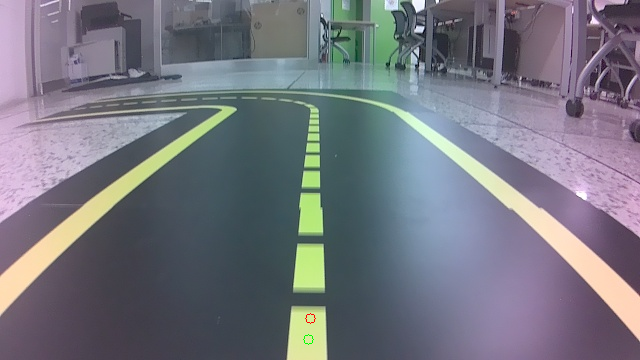

In [23]:
import cv2
import copy
import numpy as np
import PIL.Image

img_filename_fmt = 'dataset/images/frame_right_{:09d}.jpg'
ann_filename = 'dataset/annotation_right.txt'
with open(ann_filename, 'r') as f:
    data = [line.split() for line in f.readlines()]

print(data)
# xpos, ypos는 손으로 찍은 좌표 = 훈련
filename, xpos, ypos = data[3]

xpos = int(xpos)
ypos = int(ypos)

image_ori = PIL.Image.open(filename)
width = image_ori.width
height = image_ori.height

with torch.no_grad():
    image = preprocess(image_ori)
    output = model(image).detach().cpu().numpy()

# x, y는 구한 모델로 예측한거 
print(output)
x, y = output[0]

x = (x / 2 + 0.5) * width
y = (y / 2 + 0.5) * height
print(x, y)

image_np = copy.deepcopy(np.asarray(image_ori))
cv2.circle(image_np, (int(x), int(y)), radius=5, color=(255, 0, 0))  # Pred
cv2.circle(image_np, (xpos, ypos), radius=5, color=(0, 255, 0))     # GT

PIL.Image.fromarray(image_np)



[[0.36238205 0.41397682]]
435.9622573852539 254.51582729816437


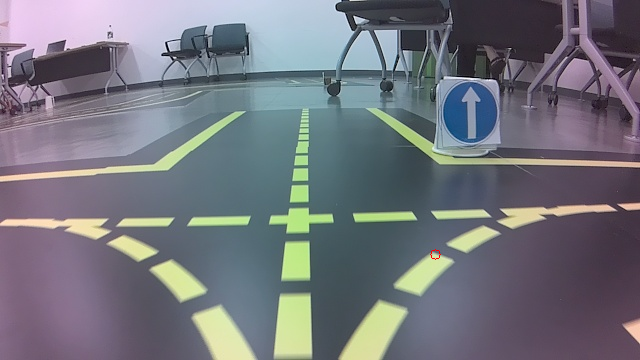

In [15]:
import cv2
import copy
import numpy as np
import PIL.Image

img_filename_fmt = 'dataset/images/frame_ano_straight_000000120.jpg'
filename = img_filename_fmt

image_ori = PIL.Image.open(filename)
width = image_ori.width
height = image_ori.height

with torch.no_grad():
    image = preprocess(image_ori)
    output = model(image).detach().cpu().numpy()

# x, y는 구한 모델로 예측한거 
print(output)
x, y = output[0]

x = (x / 2 + 0.5) * width
y = (y / 2 + 0.5) * height
print(x, y)

image_np = copy.deepcopy(np.asarray(image_ori))
cv2.circle(image_np, (int(x), int(y)), radius=5, color=(255, 0, 0))  # Pred

PIL.Image.fromarray(image_np)

